# 3. RNNs & attention.

## 	Computer Practicum for 317 group, spring 2019

Start: 14.04.19

Deadline (soft): 25.04.19 06:00

In this task you should implement a sequence to sequence model (https://arxiv.org/abs/1409.3215),
using RNNs (e. g. LSTM by Schmidhuber et al.) and attention models (https://arxiv.org/abs/1409.0473).

You are not allowed to copy and paste uncredited code from any sources.
If you do, you must CITE the source and provide EVERY line of the copied code with a comment expalining what the corresponding line does. You will be punished for borrowings (even for the cited ones) with some deduction from your final score (which is left to the ultimate discretion of the teaching assistant).  Of course, we will not trigger on every minor similarity case, but we will understand that non-trivial parts of the task were copied from elsewhere.

In this assignment we will also encourage good code and punish bad code.
We also ask you to provide useful about APIs and usability of the prototypes.
You will get some extra points for good code.

``The data is taken from this competition https://datasouls.com/c/cft-contest/description#
You could refer the solution of the winners: https://spark-in.me/post/cft-spelling-2018, ``

In [0]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from torch.optim.lr_scheduler import StepLR

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tqdm
import copy
from collections import Counter, defaultdict

import pickle

from IPython import display
sns.set()

%matplotlib inline
%load_ext autoreload
%autoreload 2

## The datasets and dataloaders (1 point)

### Datasets

In this task you will work with sequences of tokens.
We have to map the tokens into indices to feed it into the model.
Let's create a hierarchy of classes to work with sequences for our convenience.

This class handles only one array of sequences, but it performs all the forward and backward transformations (like encoding and decoding).

In [0]:
class SeqDataset(Dataset):
    """
    A dataset containing one np array of strings.
    Handles encoding of strings to word index arrays,
    backward decoding.
    """
    # It is strongly recommended to work with batches,
    # not with single sequebces.
    # As the sequences are of different length and batches are 'rectangular',
    # we introduce a special token for padding
    PAD = "ø"
    # In this task we will work only with the known tokens extracted from the dataset
    # But we shouldn't crash randomly if we encounter an unknown token.
    # We introduce a token to replace any unknown token
    UNK = "?"
    # We will feed the decoder with a start-of-sequence token as the first input
    SOS = "^"
    # The end-of-sequence token. We append it to the end of every sequence 
    # so that the RNN would know that the sequence is finished.
    # Followed by the end of the tensor or PAD tokens.=
    EOS = "$"
    def __init__(self, X, token_list):
        """
        X: np.ndarray of strings
        token_list: list of tokens
        token_list must be disjoint with special_tokens
        """
        super().__init__()
        
        assert isinstance(token_list, list)
        
        self.X = X
        self.token_list = token_list
        self.special_tokens = [self.PAD, self.UNK, self.SOS, self.EOS]
        
        assert not (set(self.special_tokens) & set(self.token_list))
        
        self.tokens =  self.special_tokens + token_list
        self.encoder = {
            token: token_id
            for token_id, token in enumerate(self.tokens)
        }
        
        # We will need it later
        self.pad_id = self.encoder[self.PAD]
        self.unk_id = self.encoder[self.UNK]
        self.sos_id = self.encoder[self.SOS]
        self.eos_id = self.encoder[self.EOS]
    
    def __len__(self):
        return len(self.X)
    
    def encode(self, sequence):
        """
        sequence: a sequence (a string)
        result: list of token indices with eos index in the end, 
        len(result) == len(sequence) + 1
        """
        result = []
        for word in sequence:
            if word in self.encoder.keys():
                result.append(self.encoder[word])
            else:
                result.append(self.unk_id)
        result.append(self.eos_id)
        #### TODO
        
        return result
    
    def decode(self, sequence, keep_pad=False):
        """
        sequence: array of word indices
        keep_pad: boolean flag whether decoding should stop when eos token is seen
        
        returns: 
            if keep_pad returns a list of all tokens (including EOS and PAD)
            if not keep_pad returns a string of tokens, dropping EOS and PAD
        """
        result = []
        for idx in sequence:
            token = self.tokens[idx]
            if token == self.EOS and not keep_pad:
                break
            result.append(token)
        
        if keep_pad:
            return result
        return "".join(result)
    
    def encode_batch(self, sequences):
        return [self.encode(sequence) for sequence in sequences]
    
    def decode_batch(self, sequences, keep_pad=False):
        return [self.decode(sequence, keep_pad) for sequence in sequences]    
    
    def prepare_item(self, item):
        """
        item: an item from dataset
        result: dict with 
            'raw':string without word index encoding
            'item': word index encoded string
            'len':len of the raw string
            'mask':has 1 on positions where item[postions] != pad_id
            (for one line it is [1]*len(item))
        """
        result = {}
        result["raw"] = item
        result["item"] = torch.from_numpy(np.array(self.encode(item)))
        result["len"] = len(item)
        result["mask"] = (result["item"] != self.pad_id).float()
        
        return result
    
    def extract_item(self, cur_x):   
        """
        You might use this function to perform some
        transformations if you don't want to store the
        transformation results
        """
        return cur_x
        
    def __getitem__(self, idx):
        result = {}
        
        cur_x = self.extract_item(self.X[idx])
        
        result["x"] = self.prepare_item(cur_x)
        return result
        

Test the class. Notice that it should work not only with single letters, but with arbitrary tokens.

In [0]:
X = [['мама', 'мыла', 'раму'], ['папа', 'чинил', 'раму']]
token_list = ['мама', 'папа', 'раму']

dataset = SeqDataset(X, token_list)
elem_0, elem_1 = dataset[0], dataset[1]

In [0]:
# test EOS token 
assert elem_0['x']['item'][-1] == dataset.eos_id
assert elem_1['x']['item'][-1] == dataset.eos_id

# test tokens and result matching
assert dataset.tokens[elem_0['x']['item'][0]] == X[0][0]
assert dataset.tokens[elem_1['x']['item'][0]] == X[1][0]

# test UNK token
assert elem_0['x']['item'][1] == dataset.unk_id
assert elem_1['x']['item'][1] == dataset.unk_id
assert dataset.decode(elem_0['x']['item']) == 'мама?раму'
assert dataset.decode(elem_1['x']['item']) == 'папа?раму'

As we are going to work in the sequence to sequence setting, we will use two sequences (input and the correct output).
The following class inherits the previous class (simply adding Y).

In [0]:
class Seq2SeqDataset(SeqDataset):
    """
    Same as the previous,
    but it handles two columns: input sequence and output sequence
    """
    def __init__(self, X, Y, token_list):
        super().__init__(X, token_list)
        assert len(X) == len(Y)        
        self.Y = Y
        
    def extract_item(self, cur_x, cur_y):            
        return cur_x, cur_y
        
    def __getitem__(self, idx):
        result = {}
        
        cur_x, cur_y = self.extract_item(self.X[idx], self.Y[idx])
        
        result["x"] = self.prepare_item(cur_x)
        result["y"] = self.prepare_item(cur_y)
        
        return result

This function splits the data into train, test and validaton datasets.

In [0]:
def prepare_dataset(X, Y, token_list, train_val_test=[0.8,0.1,0.1]): 
    """
    X, Y: np.ndarrays of equal length, X -- input sequence, Y -- output sequence
    token_list -- list of tokens from BOTH X and Y
    train_val_test: ratio to split the dataset
    """
    assert isinstance(X, np.ndarray) and isinstance(Y, np.ndarray)
    assert sum(train_val_test) == 1.0
    assert len(X) == len(Y)
                      
    train_size = int(len(X) * train_val_test[0])
    val_size = int(len(X) * train_val_test[1])
    test_size = len(X) - train_size - val_size
    
    indices = np.arange(len(X))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    train = Seq2SeqDataset(X[train_indices], Y[train_indices], token_list)
    val = Seq2SeqDataset(X[val_indices], Y[val_indices], token_list)
    test = Seq2SeqDataset(X[test_indices], Y[test_indices], token_list)
    
    return train, val, test

### Data loaders

At first you could work with a toy problem: sequence reversal. Dataset is generated randomly.

In [0]:
def get_tokens(df):
    """
    df: dataframe from the CTF competition
    returns: a list of all tokens in the data frame
    """
    counter = Counter()
    
    for original, corrected in zip(df["fullname"], df["fullname_true"]):
        counter.update(original)
        if not pd.isna(corrected):
            counter.update(corrected)
            
    return list(counter.keys())

def random_word(length, alphabet):
    """
    length: int, the exact length of sequence to generate
    alphabet: a list of tokens to generate from
    returns: a string of random tokens of desired length
    """
    token_indexes = np.random.randint(0, len(alphabet), length)
    token = "".join([alphabet[x] for x in token_indexes])
    return token

Function `generate_random_reverse_dataset` generates the dataset of random sequences.

In [0]:
def generate_random_reverse_dataset(n_samples, max_len, token_list, unique_x = True, train_val_test=[0.8,0.1,0.1]):    
    """
    n_samples: size of the dataset
    max_len: maximum length of the sequences to genretate
    unique_x: every x must be unique in the dataset
    train_val_test: list of ratios to split the dataset
    
    returns: 3 Seq2Seq datasets
    """
    new_X = []
    new_Y = []
    
    seen_x = set()
    while len(new_X) < n_samples:  
        x = random_word(max_len, token_list)
        y = "".join(reversed(x))
        
        if x in seen_x:
            continue
        
        if unique_x:
            seen_x.add(x)
        new_X.append(x)
        new_Y.append(y)
    
    
    X = np.array(new_X)[:n_samples]
    Y = np.array(new_Y)[:n_samples]
    
    train, val, test = prepare_dataset(X, Y, token_list, train_val_test)    
    
    return train, val, test


The collate_sequences function is used by the DataLoader to merge separate results of `Seq2SeqDataset.__getitem__` into tensors of required shape, to prepare the masks et c.

**Hint:** use pad_sequence from pytorch.

In [0]:
def collate_sequences(sample_list):
    """
    sample_list: list of samples, 
    each was provided by dataset.__getitem__(idx)
    """
    
    ######### TODO
    x = []
    y = []
    mask_x = []
    mask_y = []
    raw_x = []
    raw_y = []
    len_x = []
    len_y = []
    for sample in sample_list:
        x.append(sample['x']['item'])
        y.append(sample['y']['item'])
        raw_x.append(sample['x']['raw'])
        raw_y.append(sample['y']['raw'])
        len_x.append(sample['x']['len'])
        len_y.append(sample['y']['len'])
        
    x = pad_sequence(x, batch_first=True, padding_value=0)
    y = pad_sequence(y, batch_first=True, padding_value=0)
    mask_x = (x != 0).float() # 0 is pad_id
    mask_y = (y != 0).float()
        
    result = dict(x=x, y=y, mask_x=mask_x, mask_y=mask_y, raw_x=raw_x, raw_y=raw_y, len_x=len_x, len_y=len_y)
    
    return result

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

Please check various lengths of random sequences (up to several hundreds) and look at performance.
Check LSTMs and GRUs

In [0]:
train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

Test you code once more:

In [0]:
def check_batch_structure(batch, train_batcher):
    assert isinstance(batch['raw_y'][0], str)
    assert isinstance(batch['raw_x'][0], str)

    assert isinstance(batch['x'], torch.Tensor)
    assert batch['x'].dtype == torch.int64

    assert isinstance(batch['y'], torch.Tensor)
    assert batch['y'].dtype == torch.int64

    assert torch.all(batch['x'][np.arange(len(batch['x'])), batch['len_x']] == train.eos_id)
    assert torch.all(batch['y'][np.arange(len(batch['y'])), batch['len_y']] == train.eos_id)
    
    for row, row_len, row_mask in zip(batch['x'], batch['len_x'], batch['mask_x']):
        for position, (char_id, mask_value) in enumerate(zip(row, row_mask)):
            if position < row_len:
                assert char_id not in train_batcher.dataset.encode(train_batcher.dataset.special_tokens)
                assert mask_value == 1.0
            elif position == row_len:
                assert char_id == train_batcher.dataset.eos_id
                assert mask_value == 1.0
            else:
                assert char_id == train_batcher.dataset.pad_id
                assert mask_value == 0.0
            

In [0]:
# an ugly way to take the first batch
for batch in train_batcher:
    break
    
check_batch_structure(batch, train_batcher)

Please, do not remove the outputs of your experimental models from the notebook.
If the training is not interrupted extremely early, keep the plots.
In the end of the notebook describe everything you tried.
Track the bugs you spawn and then list them in the conclusion.
The best bugs will be awarded.

## Seq2Seq losses (1 point)

In the next cell we define the losses we will track in this task.

In [0]:
def seq2seq_loss(log_probs, y, mask_y, pad_value):
    """
    log_probs: logs of probability
    Please, keep your usage of softmax, 
    logsoftmax, crossentropy etc consistent
    
    It is advised to ignore pad_values in y.
    Refer documentation of (e.g) nll_loss.
    """
    ##### TODO
    result = F.nll_loss(log_probs, y)
    assert result.shape == torch.Size()
    return result

In [0]:
def seq2seq_accuracy(pred, true):
    """
    The target metric for all the tasks.
    Fraction of exact matches of the strings
    """
    
    assert len(pred) == len(true)
    corrects = 0
    for cur_pred, cur_true in zip(pred, true):
        corrects += cur_pred == cur_true
        
    return corrects/len(pred)

def character_accuracy(pred, true):
    """
    Returns: fraction of correct characters in the batch
    and
    mean fraction of correct characters for every prediction-answer pair
    """
    assert len(pred) == len(true)

    total_characters = 0
    values = []
    lengths = []
    for cur_pred, cur_true in zip(pred, true):
        values.append(sum([c1 == c2 for c1, c2 in zip(cur_pred, cur_true)]))
        cur_len = max(len(cur_true), len(cur_pred))
        lengths.append(cur_len)
            
    
    values = np.array(values)
    lengths = np.array(lengths)

    return (values/lengths).mean(), values.sum()/lengths.sum()

This class is created to hide the batch structure and how to use the model.
It is supposed to be convenient.
If used properly, it can facilitate even major changes of the API of the model class.

The idea is that if you significantly change some functions of the model, you'll only have to change their calls in this class.

In [0]:
class Seq2SeqUser:
    """
    A helper class that knows structure of the batch and losses.
    Should facilitate API changes
    """
    
    def __init__(self, dataset):
        # we keep track 
        self.dataset = dataset
        
        self.samples = []
        self.raw_samples = []
        self.attention_weights = []

    def train_forward(self, model, batch, params):
        """
        Forward function during training can be very distinct from the 
        forward function during usage,
        as we can use teacher forcing (and we have the correct answer)
        """
        result = model.train_forward(
            batch['x'], batch['mask_x'], batch['len_x'], 
            batch['y'], batch['mask_y'], batch['len_y'], 
            teacher_forcing_prob=params['teacher_forcing_prob']
        )
        return result
    
    def forward(self, model, batch, params):
        """
        The 'fair' forward (which has no access to the ground truth)
        """
        result = model.forward(
            batch['x'], batch['mask_x'], batch['len_x'], 
            max_output_length=batch['y'].shape[1]
        )
        return result

    def compute_loss(self, forward_result, batch, params):
        """
        forward_result: the output of train_forward
        batch: the batch that generated the forward_result
        
        returns: scalar tensor, loss on the batch
        
        The function that knows what loss function we have and how
        to call it with forward_result and the batch
        """
        
        log_probs, preds, debug_info = forward_result
        result = seq2seq_loss(
            log_probs, batch['y'], batch['mask_y'],
            pad_value=self.dataset.pad_id
        )
        return result
    
    def compute_target_metric(self, forward_result, batch, params):
        """
        forward_result: the output of train_forward
        batch: the batch that generated the forward_result
        
        returns: float, the target metric on the batch
        
        Computes the metric we aim to improve, but we
        cannot optimize it (for instance, the number of perfect matches)
        """
        
        log_probs, preds, debug_info = forward_result
        text_preds = self.dataset.decode_batch(preds)
        
        target_metric = seq2seq_accuracy(text_preds, batch['raw_y'])
        
        return target_metric
    
    def compute_eval_metrics(self, forward_result, batch, batch_id, tag, params):
        """
        forward_result: the output of train_forward
        batch: the batch that generated the forward_result
        batch_id: number of the batch in the dataset
        tag: dataset tag
        
        
        returns: dict of string => float
        
        Function that computes all other metrics we might wish, 
        but we don't optimize them or aim to improve
        """
        log_probs, preds, debug_info = forward_result
        text_preds = self.dataset.decode_batch(preds)
        
        # Use this code to track the evolution of predictions
        # Not the best way, actually.
        """
        if batch_id == 0 and tag == "val":
            n_samples = params.get("print_eval_max", 0)
            answers = list(zip(batch['raw_x'], text_preds, batch['raw_y']))[:n_samples]
            self.samples.append(answers)
            self.raw_samples.append(
                list(zip(
                    self.dataset.decode_batch(batch['x'], keep_pad=True), 
                    self.dataset.decode_batch(preds, keep_pad=True),
                    self.dataset.decode_batch(batch['y'], keep_pad=True)
                ))[:n_samples]
            )
            self.attention_weights.append(debug_info['attention_weights'][:n_samples])
            for answer in answers:
                print("{} || {} || {}".format(*answer))

        """
        char_acc = character_accuracy(text_preds, batch['raw_y'])
        
        result = dict(zip(["char_acc_micro", "char_acc_macro"], char_acc))
        
        return result
    
    
    def use(self, model, sequence, max_output_length=100):
        """
        model: sequence to sequence model
        sequence: list of tokens
        returns: decoded string, matrix of predictions and debug_info 
        (attention matrix, original and predicted sequences with padding)
        """
        
        item = self.dataset.prepare_item(sequence)
        
        x = item['item']
        with torch.no_grad():
            log_probs, preds, debug_info = model.forward(
                x.reshape(1, -1), 
                item['mask'].reshape(1, -1), 
                np.array([item['len']]),
                max_output_length=max_output_length
            )
        decoded = self.dataset.decode_batch(preds)
        
        debug_info['decoded_padded'] = self.dataset.decode(preds[0], keep_pad=True)
        debug_info['sequence_padded'] = self.dataset.decode(x, keep_pad=True)
        
        return decoded, preds.detach().numpy(), debug_info
        

## The model (4 points)

There're plenty asserts in the class and below!

* **2 points** for a basic rnn (LSTM or GRU seq2seq without attention)
* **2 points** for rnn attention


__KEEP ALL THE CODE FOR ALL MODELS THAT YOU TRY (AND WHICH ARE TRAINABLE)__

#### Model description

Complete the following model.
You can change the APIs, but please comment that.
You can change the parameters of the constructor freely (but keep sos_id and eos_id)
Try implementing several different models.
For instance, a simple unidirectional seq2seq without attention.
Try building a general model where you can switch between various modes (GRU, LSTM, number of directions, number of layers, dropout, kinds of attention) by passing parameters.

If you train on GPU, try training on CPU and check, if the impact of the GPU is as big as you expect. Describe what you see.

If you use GPU, try inserting *.to(device), *.cuda() as little as possible.

Try boosting the encoder by using built-in torch.LSTM.

Все модели обучались полностью на GPU

In [0]:
class AttentionModel(nn.Module):
    def __init__(self, embedding_size,
                 hidden_size, num_layers, num_directions, vocabulary_size,
                 sos_id, eos_id,
                 use_attention=True,
                 **params):
        super().__init__()
        
        self.eos_id = eos_id
        self.sos_id = sos_id
        
        self.use_attention = use_attention
        
        self.params = params
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.vocabulary_size = vocabulary_size
        self.num_directions = num_directions
        #self.num_directions = 1
        self.num_layers = num_layers
        
        self.effective_hidden_size = num_layers * self.hidden_size * self.num_directions
        self.encoder_output_size = self.num_directions * hidden_size
        self.decoder_output_size = self.num_directions * hidden_size
        self.context_size = self.encoder_output_size
        self.decoder_input_size = embedding_size + self.num_directions * hidden_size        
        
        ##### TODO
        self.embeddings = nn.Embedding(vocabulary_size, embedding_size)
        if self.num_directions == 1:
            self.encoder = nn.LSTM(self.embedding_size, self.hidden_size,
                                   self.num_layers, bidirectional=False)
        else:
            self.encoder = nn.LSTM(self.embedding_size, self.hidden_size,
                                   self.num_layers, bidirectional=True)
        self.decoder = nn.LSTM(self.embedding_size, self.hidden_size * self.num_directions,
                               self.num_layers, bidirectional=False)
        if self.use_attention:
            self.decoder_lin = nn.Linear(self.num_directions * self.hidden_size + self.context_size,
                                         self.vocabulary_size)
        else:
            self.decoder_lin = nn.Linear(self.num_directions * self.hidden_size, self.vocabulary_size)
        self.decoder_soft = nn.LogSoftmax(dim=1)
        
    def encode(self, X, mask_x, len_x):
        batch_size, max_length = X.shape
        embedded = self.embeddings(X)     
                
        debug_info = defaultdict(list)
        
        #### TODO        
        rnn_input = embedded.transpose(0, 1)
        h_0 = torch.rand(self.num_layers * self.num_directions, batch_size, self.hidden_size)
        c_0 = torch.rand(self.num_layers * self.num_directions, batch_size, self.hidden_size)
        '''        
        for pos in range(max_length):
            pass
            # YOU MUST NOT iterate through the samples in the batch!
            #### TODO            
        '''
        #### TODO
        
        outputs, (hidden, cells) = self.encoder(rnn_input, (h_0, c_0))
        outputs = outputs.transpose(0, 1)
        hidden = hidden.transpose(0, 1) #hidden of shape (batch, num_layers*num_directions, hidden_size)
        cells = cells.transpose(0, 1) #same shape as hidden
        
        #if there are 2 directions, hidden and size must be concatenated for
        #decoder which is unidirectional
        if self.num_directions == 2:
            hidden = hidden.view(batch_size, self.num_layers, self.num_directions, -1)
            cells = cells.view(batch_size, self.num_layers, self.num_directions, -1)
            hidden1 = hidden[:, :, 0, :]
            hidden2 = hidden[:, :, 1, :]
            cells1 = hidden[:, :, 0, :]
            cells2 = hidden[:, :, 1, :]
            hidden = torch.cat((hidden1, hidden2), dim=2)
            cells = torch.cat((hidden1, hidden2), dim=2)
        result_state = (hidden, cells)
        return result_state, outputs, debug_info
    
    
    def attention(self, key, encoder_output, mask_x, len_x):
        debug_info = {}
        batch_size, max_length = key.shape
        input_length = encoder_output.shape[1]
        
        required_shape = (batch_size, self.num_directions * self.hidden_size)
        assert key.shape == required_shape, (key.shape, required_shape)
        
        attention_logits = (encoder_output * key.unsqueeze(dim=1)).sum(dim=2) 
        
        required_shape = (batch_size, input_length)
        assert attention_logits.shape == required_shape
        
        #### TODO
        
        attention_weights = nn.Softmax(dim=1)(attention_logits) #from Luong article
        context = (encoder_output * attention_weights.unsqueeze(dim=2)).sum(dim=1) 
                
        required_shape = (batch_size, self.context_size)
        assert context.shape == required_shape
        
        ####TMP
        return context, attention_weights.squeeze(-1)
    
    def decode(self, encoder_state, encoder_output, mask_x, len_x, max_output_length=None, real_output=None, teacher_forcing=False):   
        assert max_output_length is not None or real_output is not None
        
        if real_output is not None:
            assert max_output_length is None
            max_output_length = real_output.shape[1]
        else:
            assert real_output is None
            
        if teacher_forcing:
            assert real_output is not None
        
        batch_size = encoder_state[0].shape[0]
        debug_info = defaultdict(list)
        hidden, cells = encoder_state
        hidden = hidden.transpose(0, 1)
        cells = cells.transpose(0, 1)
        ##### TODO        
        
        last_output_ids = torch.from_numpy(np.array([self.sos_id for i in range(batch_size)]))
        
        #### TODO
        probs = torch.zeros(batch_size, self.vocabulary_size, max_output_length)
        preds = torch.zeros(batch_size, max_output_length, dtype=torch.int64)
        
        for step_id in range(max_output_length):
            if step_id > 0 and teacher_forcing:
                last_output_ids = real_output[:, step_id - 1]
            last_output = self.embeddings(last_output_ids)
            last_output = torch.unsqueeze(last_output, dim=0)
            #### TODO
            output, (hidden, cells) = self.decoder(last_output, (hidden, cells))
            output = torch.squeeze(output, 0) # shape - (batch_size, self.num_directions * self.hidden_size)
            
            if self.use_attention:
                context, attention_weights  = self.attention(output, encoder_output, mask_x, len_x)
                output = torch.cat((context, output), dim=1)
                #### TODO
           
            res = self.decoder_lin(output) # shape - (batch_size, vocabulary_size)
            res = self.decoder_soft(res)
            probs[:, :, step_id] = res
            last_output_ids = res.argmax(dim=1) #should i use attention in input
            preds[:, step_id] = last_output_ids
            
                
        return probs, preds, debug_info
    
    
    def forward(self, x, mask_x, len_x, max_output_length): 
        #### TODO
        encoder_state, encoder_output, _ = self.encode(x, mask_x, len_x)
        decoded = self.decode(encoder_state, encoder_output, mask_x, len_x,
                                      max_output_length, None, False)
        return decoded
        
    
    def train_forward(self, x, mask_x, len_x, y, mask_y, len_y, teacher_forcing_prob=0.0):
        teacher_forcing = False
        if np.random.rand() < teacher_forcing_prob:
            teacher_forcing = True
        
        if not teacher_forcing:
            max_output_length = y.shape[1]
            y = None
        else:
            max_output_length = None
        
        encoder_state, encoder_output, _ = self.encode(x, mask_x, len_x)
        decode = self.decode(encoder_state, encoder_output, mask_x, len_x,
                                      max_output_length, y, teacher_forcing)
        
        
        return decode

Create a model here for testing:

In [0]:
seq2seq_model_uni = AttentionModel(
    64, 128, 3, 1, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=False,
    params={'encoder_use_last_valid_state':True},
)

Define a loss object on the train dataset:

In [0]:
loss_object = Seq2SeqUser(train)

Example of reasonable parameters:

In [0]:
params = {
    "epochs":15,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(10, 5),
        "show_every":10
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}

Some tests as always:

In [0]:
# # an ugly way to take the first batch
for batch in train_batcher:
    break
    
forward_result = loss_object.train_forward(seq2seq_model_uni, batch, params)

assert forward_result[1].dtype == torch.int64
assert isinstance(forward_result[2], defaultdict)

loss = loss_object.compute_loss(forward_result, batch, params)
assert loss.requires_grad == True

# A randomly initialize model is expected to have losses (on this token set) like this
print(loss)
assert 4.0 <= loss and loss <= 4.5

tensor(3.5855, grad_fn=<NllLoss2DBackward>)


AssertionError: ignored

In [0]:
max_output_length = 59
decoded, predictions, debug_info = loss_object.use(
    seq2seq_model_uni, list("пушкиналександрсергеевич"), max_output_length=max_output_length
)

assert isinstance(decoded, list)
assert isinstance(decoded[0], str)

assert isinstance(predictions, np.ndarray)
assert predictions.shape == (1, max_output_length)

The following class is to facilitate the training process.

In [0]:
class Trainer:
    def __init__(self, model, optimizer, backward_callback=None, iteration_callback=None):
        """
        model: a seq2seq model
        optimizer: an optimizer to optimize the model
        Use the callbacks for lr scheduling and gradient clipping
        """
        self.model = model
        self.optimizer = optimizer
        self.iteration_callback = iteration_callback
        self.backward_callback = backward_callback
        
        self.metrics = defaultdict(list)
        self.metric_steps = defaultdict(list)
        self.total_epochs = 0
        self.total_iterations = 0
    
    
    def log(self, value, tag, step):
        """
        value: tensor or float
        tag: string, name of the logged value
        step: iteration of the process
        """
        if isinstance(value, torch.Tensor):
            value = value.detach().numpy()
        
        self.metrics[tag].append(value)
        self.metric_steps[tag].append(step)
 
    def show_logs(self, params):
        """
        shows the logs every show_every iterations
        """
        if self.total_iterations % params['show_every'] != 0:
            return
        
        display.clear_output()
        
        tags = sorted(self.metrics.keys())
        figures = [tag.split('/')[0] for tag in tags]
        previous_figure = None
        
        
        for tag, figure  in zip(tags, figures):
            if previous_figure != figure:
                plt.show()
                plt.figure(figsize=params['figsize'])
                plt.title(figure)
            plt.plot(self.metric_steps[tag], self.metrics[tag], label=tag)
            previous_figure = figure
            plt.legend()
        
        plt.show()
        
    def evaluate(self, batcher, loss_object, tag, params):
        """
        batcher: DatasetLodader
        loss_object: Seq2SeqUser
        tag: dataset tag (train, val)
        params: dict, evaluation params
        """
        if self.total_iterations % params['validate_every'] != 0:
            return
        
        max_batches = min(params['validation_max_batches'], len(batcher))
        self.model.eval()
        
        loss_accum = 0
        size_accum = 0
        target_metric_accum = 0
        eval_metric_dict = defaultdict(list)
        for batch_id, batch in enumerate(tqdm.tqdm_notebook(batcher, desc="evaluation", total=max_batches)):
            if batch_id > max_batches:
                break
                
            with torch.no_grad():
                forward_result = loss_object.forward(self.model, batch, params)
                loss = loss_object.compute_loss(forward_result, batch, params)
                loss = loss.detach().numpy()
            
            target_metric = loss_object.compute_target_metric(forward_result, batch, params)
            eval_metrics = loss_object.compute_eval_metrics(forward_result, batch, batch_id, tag, params)
            for key, value in eval_metrics.items():
                eval_metric_dict[key].append(value)
            
            target_metric_accum += target_metric * len(batch['x'])
            loss_accum += loss * len(batch['x'])
            size_accum += len(batch['x'])
        
        self.log(value=loss_accum/size_accum, tag="loss/eval/" + tag, step=self.total_iterations)
        self.log(value=target_metric_accum/size_accum, tag="target_metric/eval" + tag, step=self.total_iterations)
        
        for key, values in eval_metrics.items():
            self.log(value=np.mean(values), tag = key + "/eval/" + tag, step=self.total_iterations)
        
        torch.save(self.model.state_dict(), "./model_state.tc")
        torch.save((self.metrics, self.total_iterations, self.optimizer), "./trainer.tc")
        self.model.train()
    
    def train(self, train_batcher, loss_object, val_batcher, params={}):
        """
        train_batcher: DataLoader with seq2seq dataset
        loss_object: Seq2SeqUser
        val_batcher: DataLoader with seq2seq dataset
        params: dict, contains the parameters of training
        
        Runs the training process, logging the loss and displaying it
        """
        
        for epoch_id in range(params['epochs']):
            for iteration_id, batch in enumerate(tqdm.tqdm_notebook(train_batcher)):
                self.model.train()
                self.optimizer.zero_grad()
                
                iteration_start_time = time.time()
                forward_result = loss_object.train_forward(self.model, batch, params)
                loss = loss_object.compute_loss(forward_result, batch, params)
                

                    
                loss.backward()
                if self.backward_callback is not None:
                    self.backward_callback(**params['grad_params'])
                    
                self.optimizer.step()
                if self.iteration_callback is not None:
                    self.iteration_callback.step()
                
                self.log(loss, tag="loss/batch_train", step=self.total_iterations)
                self.log(time.time(), tag="time_elapsed", step=self.total_iterations)
                self.log(time.time() - iteration_start_time, tag="time/train", step=self.total_iterations)
                self.evaluate(train_batcher, loss_object, "train", params)
                self.evaluate(val_batcher, loss_object, "val", params)
                

                self.show_logs(params['log_params'])
                
                self.total_iterations += 1
            
            self.total_epochs += 1

## Experiments with simple seq2seq (2 points)

Experiments go here. Achieve some quality!

You will get the complete score only if you provide some experiments with architectures. A simple bidirectional model is able to learn reverse sequence (0.7 — 0.8 accuracy) in 2 -- 4 hours.

Don't forget to provide some plots or tables. 

### Unidirectional with max_len = 20 without clipping

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)


In [0]:
seq2seq_model_uni = AttentionModel(
    64, 128, 3, 1, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=False,
    params={'encoder_use_last_valid_state':True},
)

params = {
    "epochs":15,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(10, 5),
        "show_every":10
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}

In [0]:
# Don't forget to optimize the parameters of the CURRENT MODEL
# Try different optimizers
optimizer = torch.optim.Adam(seq2seq_model_uni.parameters())

In [0]:
trainer = Trainer(seq2seq_model_uni, optimizer)

Use the callbacks for gradient clipping (it can be important for RNNs) and learning rate scheduling.

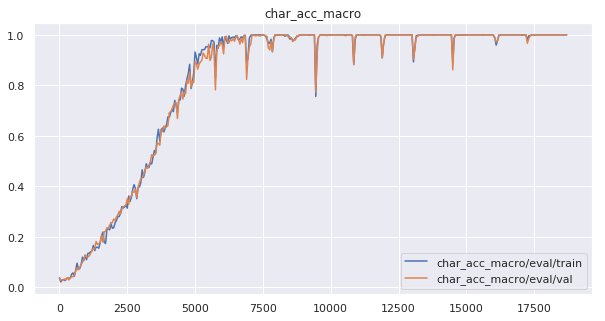

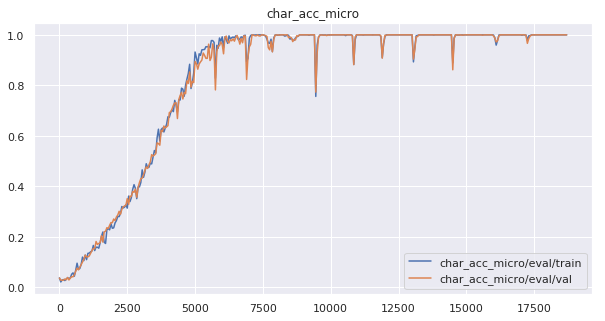

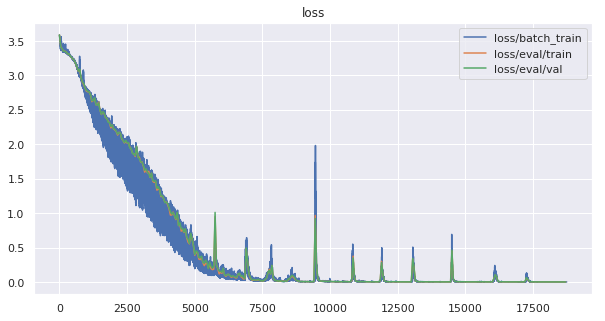

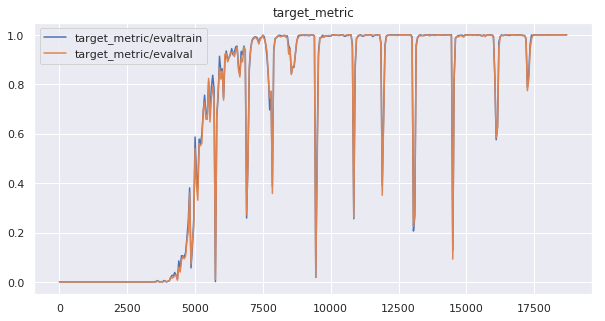

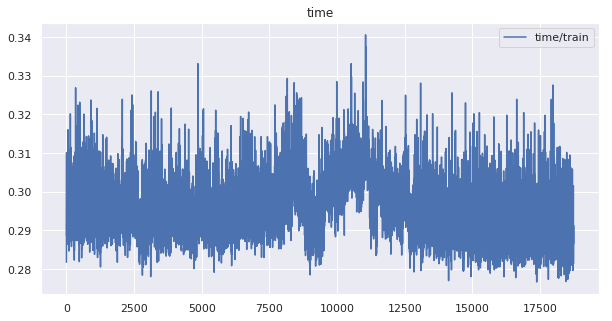

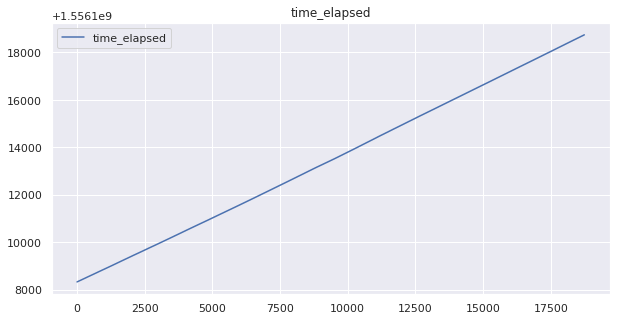

torch.Size([64, 36, 21])
torch.Size([64, 21])
torch.Size([64, 21])
torch.Size([64, 36, 21])
torch.Size([64, 21])
torch.Size([64, 21])
torch.Size([64, 36, 21])
torch.Size([64, 21])
torch.Size([64, 21])
torch.Size([64, 36, 21])
torch.Size([64, 21])
torch.Size([64, 21])
torch.Size([64, 36, 21])
torch.Size([64, 21])
torch.Size([64, 21])
torch.Size([64, 36, 21])
torch.Size([64, 21])
torch.Size([64, 21])
torch.Size([64, 36, 21])
torch.Size([64, 21])
torch.Size([64, 21])
torch.Size([64, 36, 21])
torch.Size([64, 21])
torch.Size([64, 21])
torch.Size([64, 36, 21])
torch.Size([64, 21])
torch.Size([64, 21])


In [0]:
trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)

Use this function for evaluation:

In [0]:
def evaluate_test(model, batcher, loss_object, max_batches, tag, params):
    """
    model: seq2seq model
    batcher: Dataloader, test dataset
    loss_object: Seq2SeqUser
    max_batcher: number of the first batches to evaluate
    tag: dataset name
    params: evaluation params
    
    performs the evaluation on the test dataset

    """
    max_batches=min(max_batches, len(batcher))
    model.eval()

    loss_accum = 0
    size_accum = 0
    target_metric_accum = 0
    eval_metric_dict = defaultdict(list)
    for batch_id, batch in enumerate(tqdm.tqdm_notebook(batcher, desc="evaluation", total=max_batches)):  
        if batch_id > max_batches:
            break
        with torch.no_grad():
            forward_result = loss_object.forward(model, batch, params)
            loss = loss_object.compute_loss(forward_result, batch, params)
            loss = loss.detach().numpy()

        target_metric = loss_object.compute_target_metric(forward_result, batch, params)
        eval_metrics = loss_object.compute_eval_metrics(forward_result, batch, batch_id, tag, params)
        for key, value in eval_metrics.items():
            eval_metric_dict[key].append(value)

        target_metric_accum += target_metric * len(batch['x'])
        loss_accum += loss * len(batch['x'])
        size_accum += len(batch['x'])


    result = {}
    result['loss'] = loss_accum/size_accum
    result['target'] = target_metric_accum/size_accum
    for key, values in eval_metrics.items():
        result[key] = np.mean(values) 

    model.train()

    return result

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model_uni, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model_uni, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model_uni, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [0]:
print(evaluate_result_test)
print(evaluate_result_train)
print(evaluate_result_val)

{'loss': 0.00044269860866479575, 'target': 0.9999, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
{'loss': 0.0003672261064812209, 'target': 1.0, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
{'loss': 0.0004339615787301065, 'target': 0.9998452970297029, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}


Модель сошлась примерно за 5 эпох, примерно за час с небольшим, то есть на каждую эпоху тратилось 12-13 минут.
Модель подвержена взрыву градиента (видно пики на графике лосса), соотвественно падали и метрики качества при взрыве.

### Bidirectional with length = 20 without clipping

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

In [0]:
loss_object = Seq2SeqUser(train)

In [0]:
seq2seq_model_bi = AttentionModel(
    64, 128, 3, 2, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=False,
    params={'encoder_use_last_valid_state':True},
)

params = {
    "epochs":15,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(10, 5),
        "show_every":10
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}

In [0]:
optimizer_bi = torch.optim.Adam(seq2seq_model_bi.parameters())
trainer_bi = Trainer(seq2seq_model_bi, optimizer_bi)

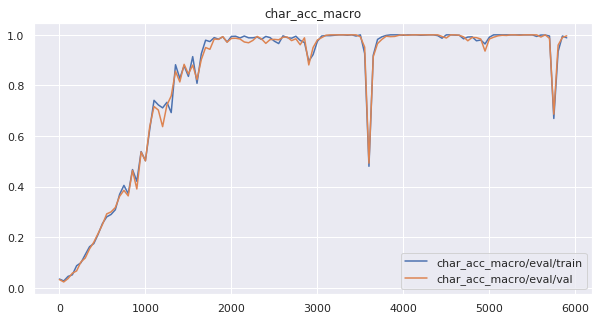

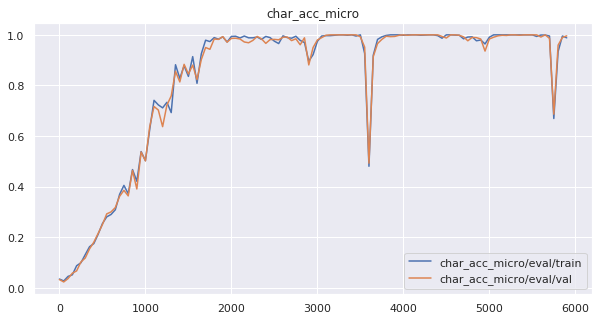

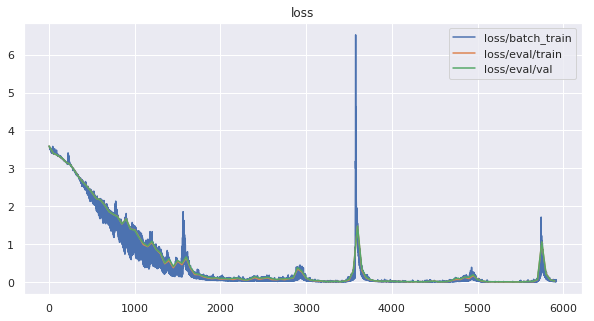

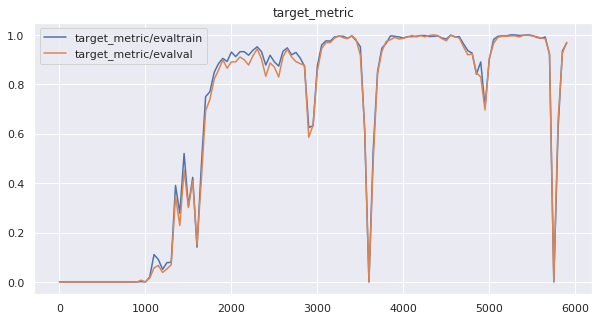

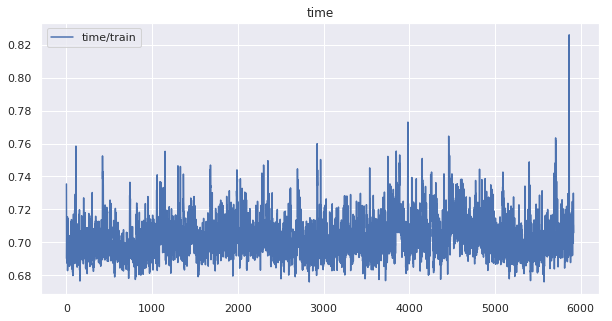

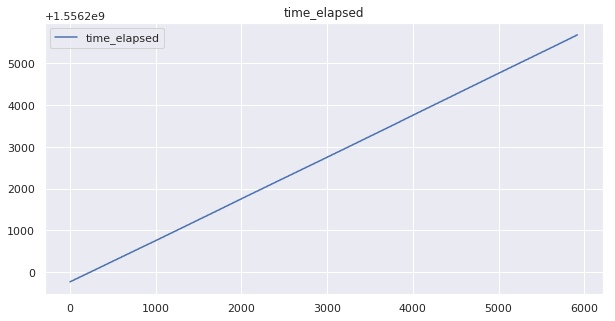

In [0]:
try:
    trainer_bi.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)
except:
    pass

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model_bi, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model_bi, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model_bi, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [0]:
print(evaluate_result_test)
print(evaluate_result_train)
print(evaluate_result_val)

{'loss': 0.02466053275913, 'target': 0.9731, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
{'loss': 0.022760325590941575, 'target': 0.9774133663366337, 'char_acc_micro': 0.990625, 'char_acc_macro': 0.990625}
{'loss': 0.02741370778438626, 'target': 0.9693688118811881, 'char_acc_micro': 0.9875, 'char_acc_macro': 0.9875}


Двунаправленная модель сошлась намного быстрее: за одну эпоху с небольшим, при этом было потрачено меньше времени, чем при однонаправленной LSTM: примерно 25 минут. Время выполнения эпохи было больше, чем у однонаправленной модели, ввиду большей сложности, но за счет более быстрой сходимости, мы получили и хороший выигрыш во времени.  Преимущество двунаправленной модели понятно, так как при работе с последовательностью мы можем смотреть не только предыдущие символы, но и последующие. Модель также подвержена взрыву градиента.



Попробуем применить некоторые методы для предотвращения взрыва градиента

### Bidirectional with length = 20 with gradient clipping

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

loss_object = Seq2SeqUser(train)

In [0]:
seq2seq_model = AttentionModel(
    64, 128, 3, 2, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=False,
    params={'encoder_use_last_valid_state':True},
)

params = {
    "epochs":15,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(10, 5),
        "show_every":10
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5,
    "grad_params": {
        "parameters": seq2seq_model.parameters(),
        "max_norm": 10.
    }
    
}

In [0]:
optimizer = torch.optim.Adam(seq2seq_model.parameters())
backward_callback = nn.utils.clip_grad_norm_
trainer = Trainer(seq2seq_model, optimizer, backward_callback=backward_callback)

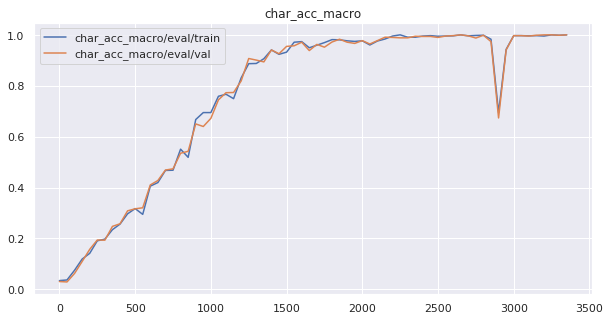

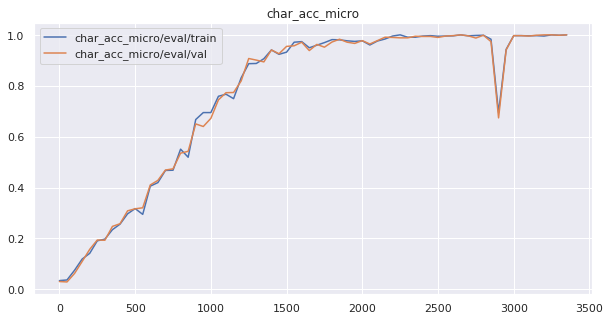

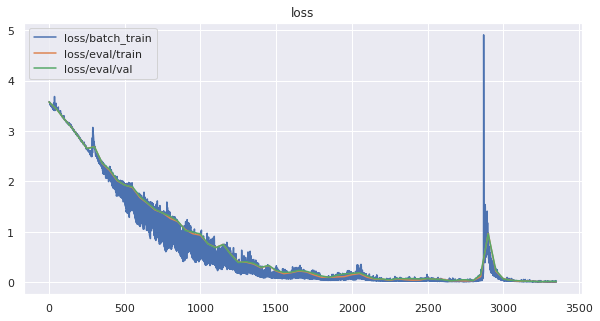

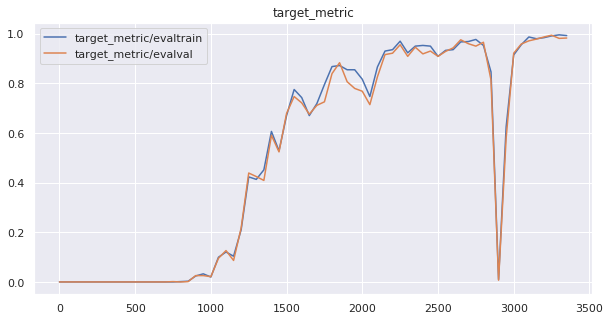

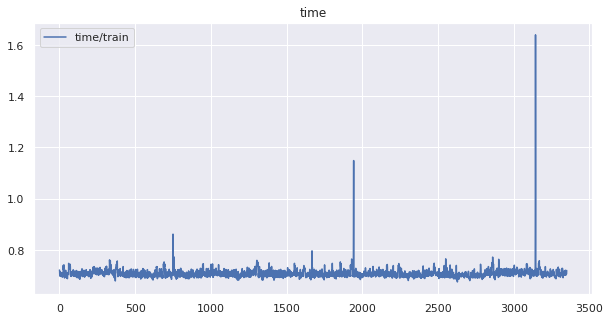

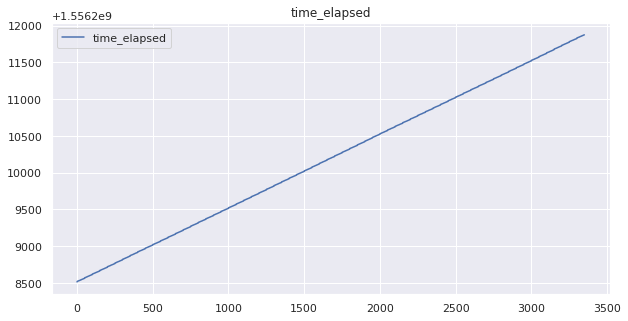

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)
except:
    pass

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [0]:
print(evaluate_result_test)
print(evaluate_result_train)
print(evaluate_result_val)

{'loss': 0.014216244155913592, 'target': 0.9892, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
{'loss': 0.00935139443430275, 'target': 0.9953589108910891, 'char_acc_micro': 0.9984375, 'char_acc_macro': 0.9984375}
{'loss': 0.01384755256724092, 'target': 0.9904084158415841, 'char_acc_micro': 0.99609375, 'char_acc_macro': 0.99609375}


Применение градиентного клиппинга не силньо помогла нам в борьбе со взрывом градиента, возможно это связано со сложностью подобрать правильный порог дял обрезки градиента, для различных моделей он разный. Модель сходится с той же скоростью, что и обычная двунаправленная, но проблема взрыва градиента не решается

### Bidirectional with length = 20 with lr scheduling

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

loss_object = Seq2SeqUser(train)

In [0]:
seq2seq_model = AttentionModel(
    64, 128, 3, 2, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=False,
    params={'encoder_use_last_valid_state':True},
)

params = {
    "epochs":15,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(10, 5),
        "show_every":10
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
}

In [0]:
optimizer = torch.optim.Adam(seq2seq_model.parameters())
iteration_callback = StepLR(optimizer, step_size=1000, gamma=0.3)
trainer = Trainer(seq2seq_model, optimizer, iteration_callback=iteration_callback)

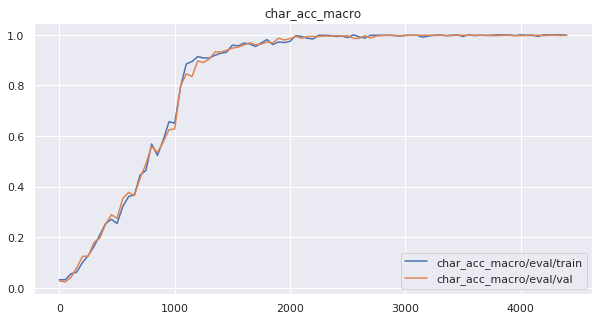

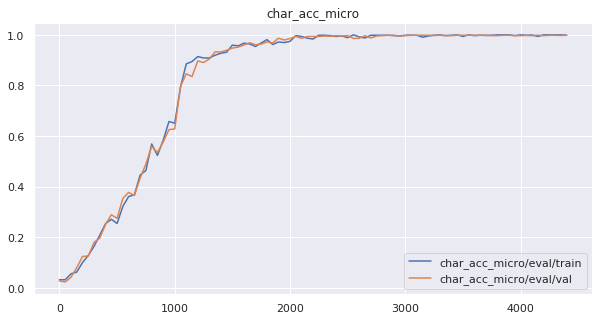

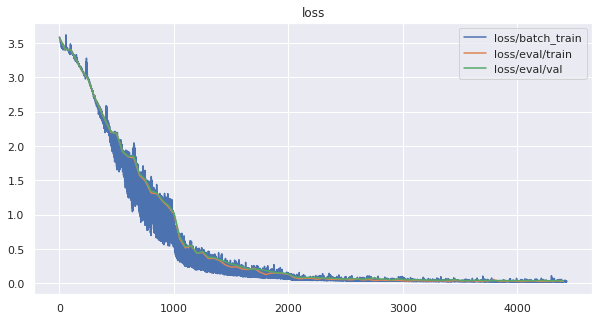

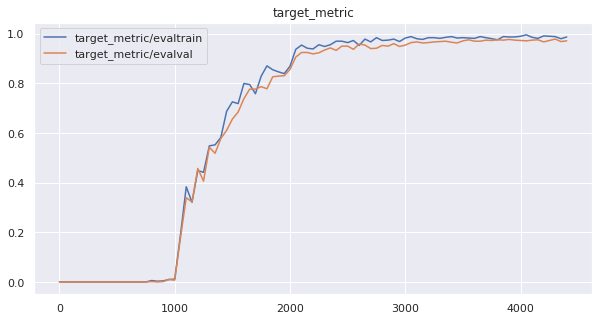

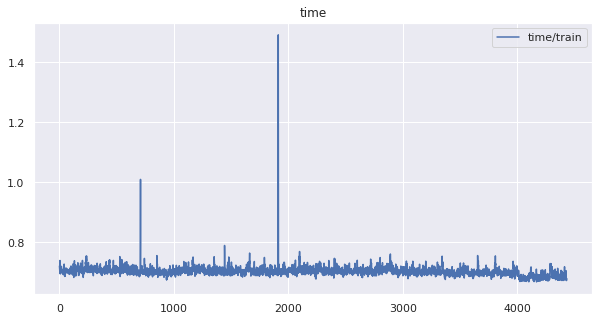

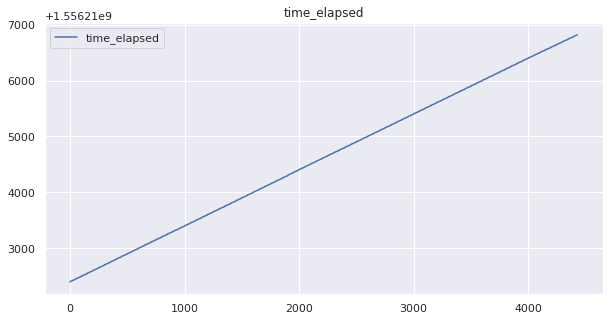

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)
except:
    pass

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [0]:
print(evaluate_result_test)
print(evaluate_result_train)
print(evaluate_result_val)

{'loss': 0.0374600635945797, 'target': 0.9768, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
{'loss': 0.028341843977127926, 'target': 0.9890160891089109, 'char_acc_micro': 0.99375, 'char_acc_macro': 0.99375}
{'loss': 0.037557279266933405, 'target': 0.978805693069307, 'char_acc_micro': 0.99296875, 'char_acc_macro': 0.99296875}


Применение lr scheduling помогло со взрывом градиента: через заданное число итераций мы уменьшаем значение темпа обучения. Взрыва градиента не происходит, loss продолжает падать, а значение accuracy все время находится в районе единицы.


Протестируем работа двунаправленной сети без внимания с lr scheduling на последовательностях меньшей и большей длины

### Bidirectional with length = 10 with lr scheduling

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=10,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

loss_object = Seq2SeqUser(train)

In [0]:
seq2seq_model = AttentionModel(
    64, 128, 3, 2, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=False,
    params={'encoder_use_last_valid_state':True},
)

params = {
    "epochs":15,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(10, 5),
        "show_every":10
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
}

In [0]:
optimizer = torch.optim.Adam(seq2seq_model.parameters())
iteration_callback = StepLR(optimizer, step_size=500, gamma=0.3)
trainer = Trainer(seq2seq_model, optimizer, iteration_callback=iteration_callback)

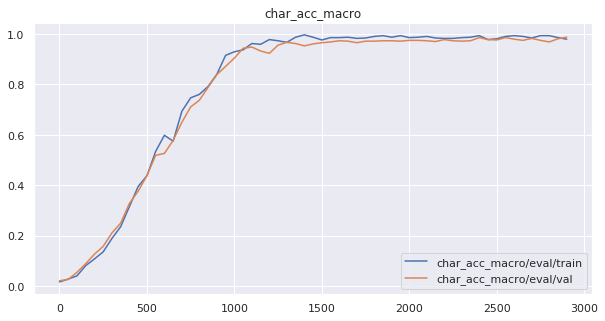

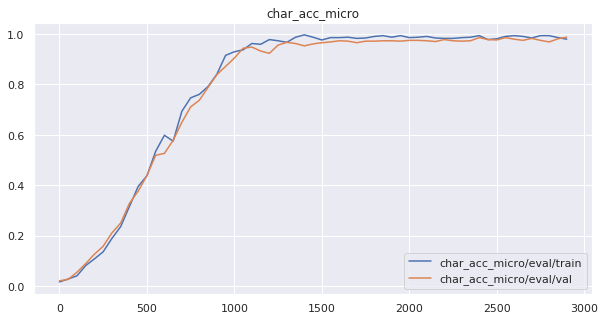

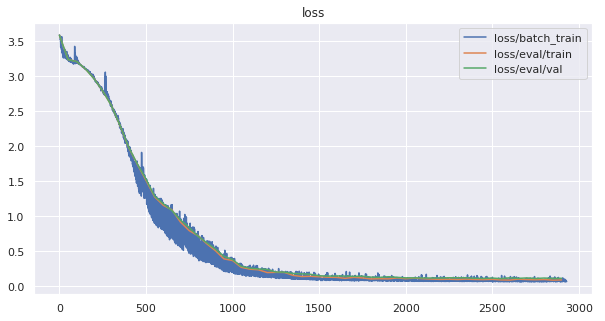

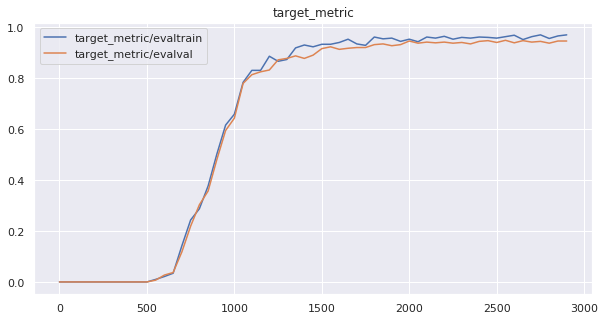

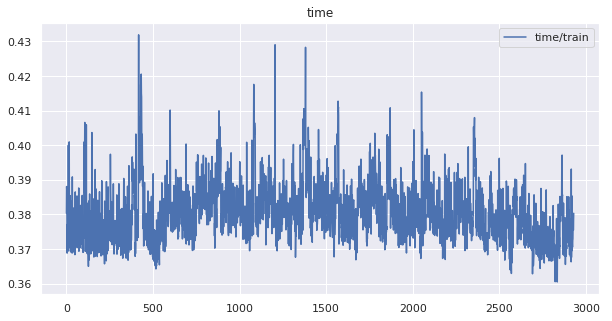

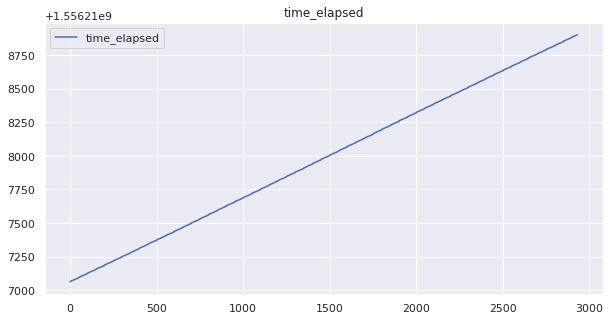

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)
except:
    pass

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [0]:
print(evaluate_result_test)
print(evaluate_result_train)
print(evaluate_result_val)

{'loss': 0.10267439373731613, 'target': 0.9528, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
{'loss': 0.09649450929448156, 'target': 0.9593131188118812, 'char_acc_micro': 0.99375, 'char_acc_macro': 0.99375}
{'loss': 0.10317349035551052, 'target': 0.9506497524752475, 'char_acc_micro': 0.9906250000000001, 'char_acc_macro': 0.990625}


Модель быстро достигает значение целевой метрики в районе единицы (чуть меньше чем за эпоху), при этом тратит на это меньше времени, чем при работе с датасетом из слов из 10 символов (ввиду очевидных причин).

### Bidirectional with length = 40 with lr scheduling

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=40,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

loss_object = Seq2SeqUser(train)

In [0]:
seq2seq_model = AttentionModel(
    64, 128, 3, 2, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=False,
    params={'encoder_use_last_valid_state':True},
)

params = {
    "epochs":15,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(10, 5),
        "show_every":10
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
}

In [0]:
optimizer = torch.optim.Adam(seq2seq_model.parameters())
iteration_callback = StepLR(optimizer, step_size=2000, gamma=0.3)
trainer = Trainer(seq2seq_model, optimizer, iteration_callback=iteration_callback)

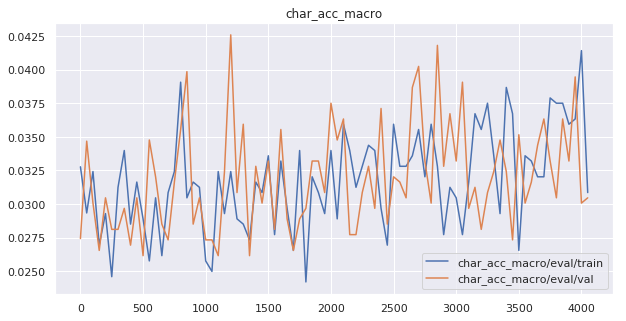

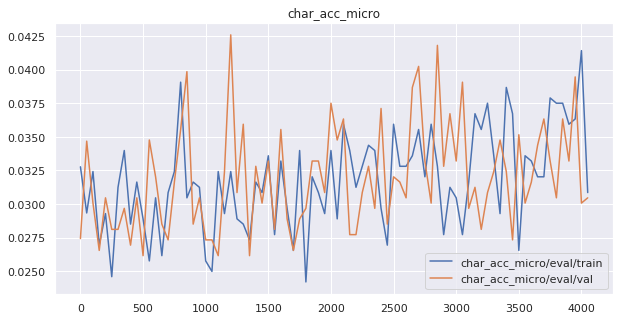

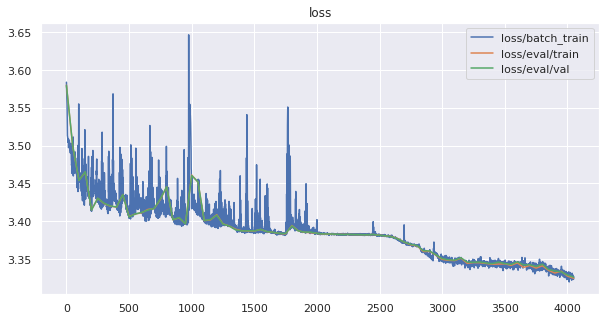

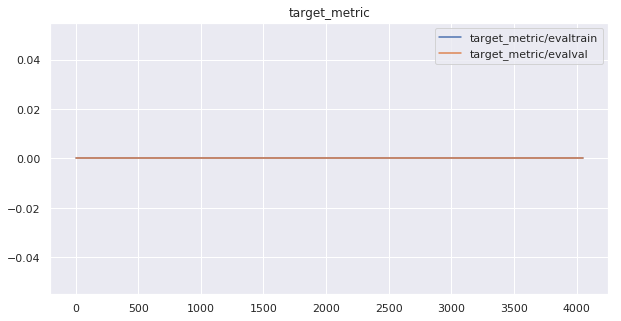

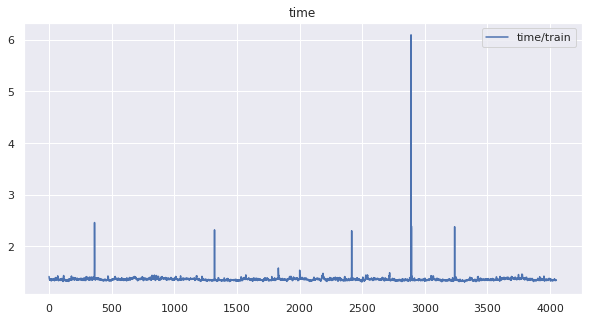

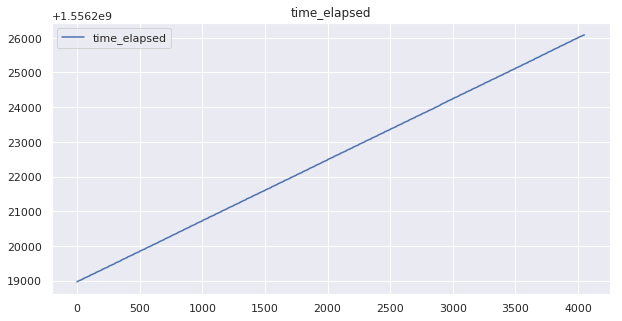

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)
except:
    pass

Двунаправленная сеть без аттеншена совсем не справляется с задачей переворота последователньости при длине в 40 символов. Лосс убывает, но очень незначительно, возможно, эпох за 50 модель и сойдется к хорошему решению, но эксперимент был прекращен ввиду его большой времязатратности

## Experiments with attention seq2seq  (2 points)

Compare performance (and times for training) of seq2seq model and attention seq2seq model.
A bidirectional model with attention and should be able to learn reverse (== copy) sequence in around 20-30 minutes. 

### One-directional RNN with max_len of sample - 20

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

In [0]:
seq2seq_model_att_uni = AttentionModel(
    64, 128, 3, 1, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=True,
    params={'encoder_use_last_valid_state':True},
)

params = {
    "epochs":10,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(10, 5),
        "show_every":10
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
    
}

In [0]:
optimizer = torch.optim.Adam(seq2seq_model_att_uni.parameters())

In [0]:
trainer_att = Trainer(seq2seq_model_att_uni, optimizer)

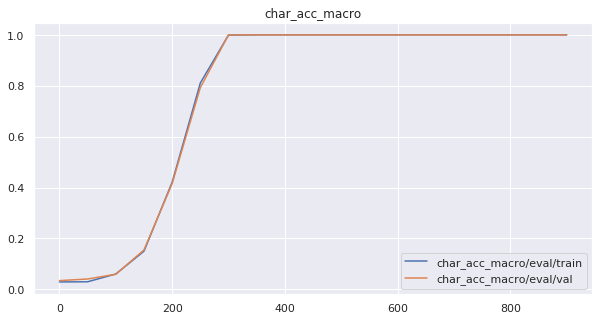

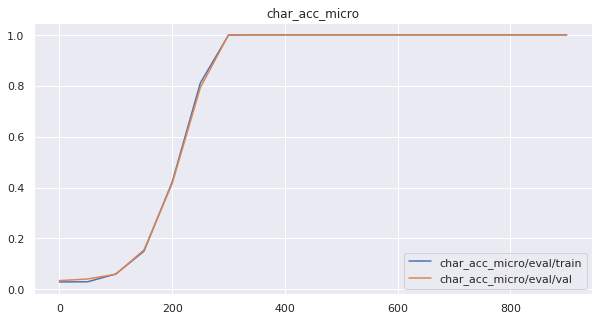

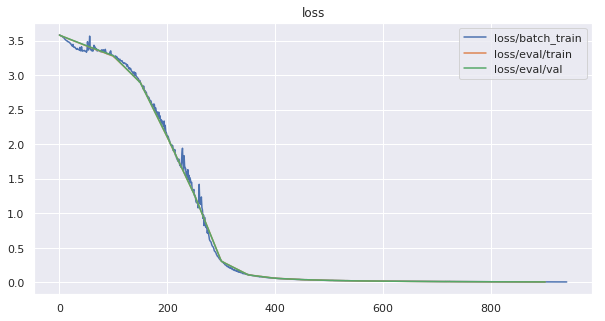

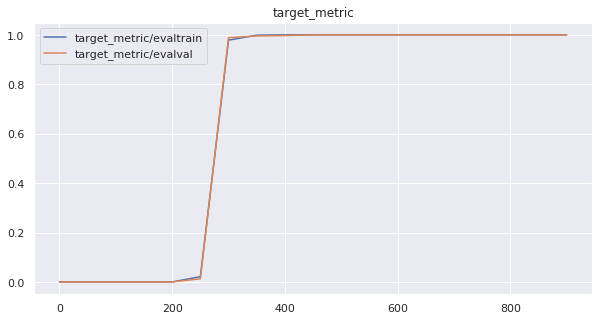

In [0]:
try:
    trainer_att.train(train_batcher=train_batcher, val_batcher=val_batcher,
                  loss_object=loss_object, params=params)
except KeyboardInterrupt:
    pass

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model_att_uni, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model_att_uni, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model_att_uni, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [0]:
print(evaluate_result_test)
print(evaluate_result_train)
print(evaluate_result_val)

{'loss': 0.006519371192157269, 'target': 1.0, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
{'loss': 0.006511958813903355, 'target': 1.0, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
{'loss': 0.006516843563923151, 'target': 1.0, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}


Просто поразительная скорость сходимости у модели со вниманием. Достигается константная единица на целевой метрики всего за треть-чеверть эпохи, и это при работе с однонаправленной LSTM сетью.

### Biderectional RNN with length = 20

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=20,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

loss_object = Seq2SeqUser(train)

In [0]:
seq2seq_model = AttentionModel(
    64, 128, 3, 2, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=True,
    params={'encoder_use_last_valid_state':True},
)

params = {
    "epochs":10,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(10, 5),
        "show_every":10
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
}

In [0]:
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

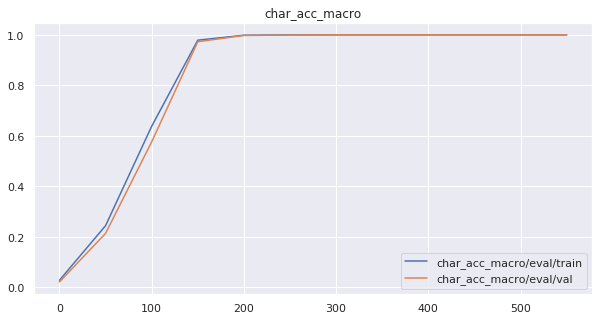

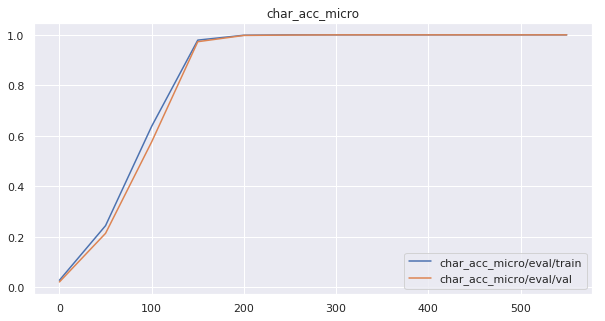

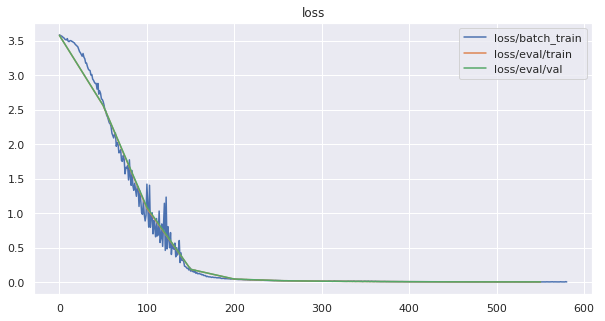

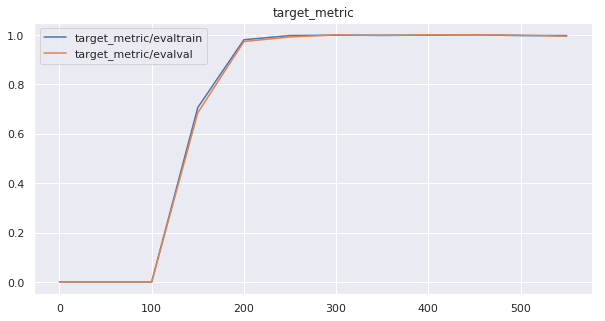

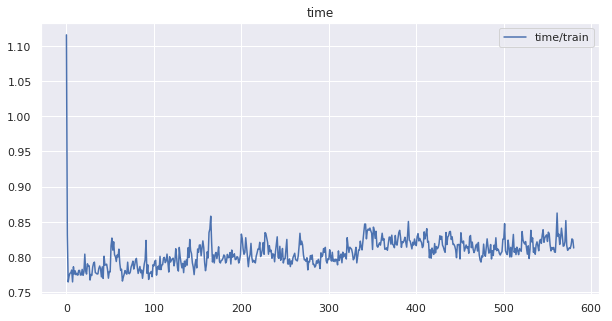

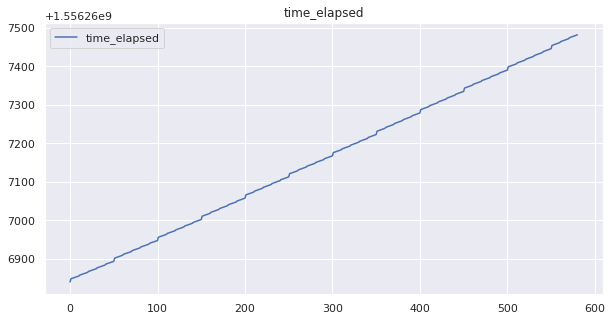

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)
except:
    pass

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [0]:
print(evaluate_result_test)
print(evaluate_result_train)
print(evaluate_result_val)

{'loss': 0.005865276280045509, 'target': 0.989, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}
{'loss': 0.0060123123486738395, 'target': 0.9900990099009901, 'char_acc_micro': 0.9984375, 'char_acc_macro': 0.9984375}
{'loss': 0.005602991148497503, 'target': 0.9910272277227723, 'char_acc_micro': 1.0, 'char_acc_macro': 1.0}


При запуске двунаправленной сети с attention результаты соответсвенно еще лучше, чем при однонаправленной, задача полностью решается уже где-то через 1/5 эпохи, при этом выполняются они всего минут за 5. Таким образом у моделей с вниманием очевидные плюсы перед моделями без внимания. Это логично, так как при декодировке мы каждый раз можем видеть нашу последовательность в прошлом, соответсвенно задача реверса становятся для данной нейросети вообще тривиальной.

Потестируем двунаправленную RNN с attention также для последовательностей других длин

### Biderectional RNN with length = 10

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=10,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

loss_object = Seq2SeqUser(train)

In [0]:
seq2seq_model = AttentionModel(
    64, 128, 3, 2, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=True,
    params={'encoder_use_last_valid_state':True},
)

params = {
    "epochs":10,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(10, 5),
        "show_every":10
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
}

In [0]:
optimizer = torch.optim.Adam(seq2seq_model.parameters())
trainer = Trainer(seq2seq_model, optimizer)

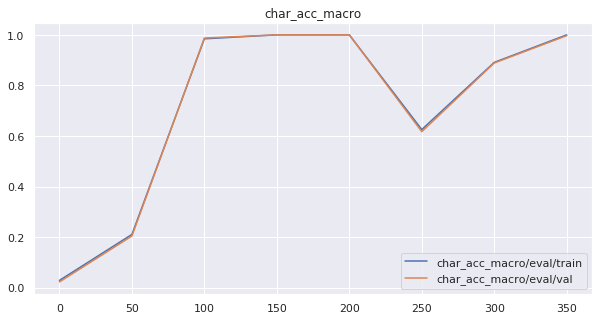

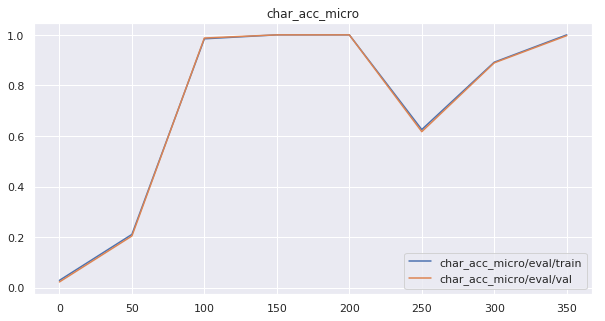

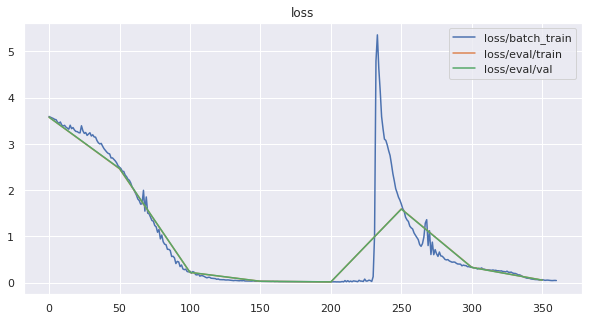

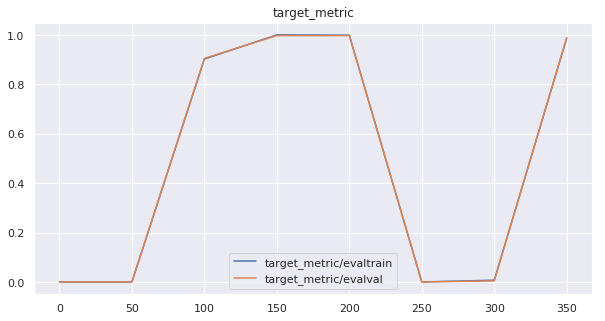

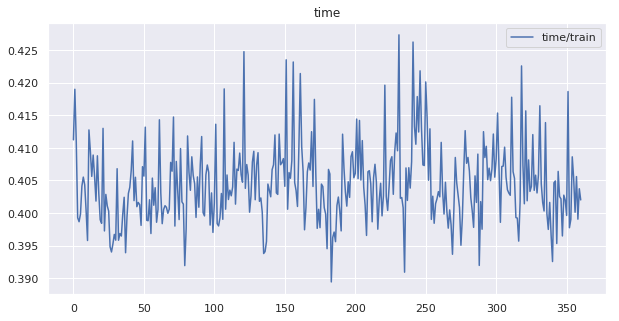

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)
except:
    pass

Для длины последовательности 10 символов, задача решается еще быстрее, но ввиду очень быстрого убывания лосса, быстро наступает пробелма взрыва градиента , учтем это и будем применять lr scheduling впоследствии для борьбы с этим.

### Biderectional RNN with length = 50

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=50,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

loss_object = Seq2SeqUser(train)

In [0]:
seq2seq_model = AttentionModel(
    64, 128, 3, 2, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=True,
    params={'encoder_use_last_valid_state':True},
)

params = {
    "epochs":10,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(10, 5),
        "show_every":10
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
}

In [0]:
optimizer = torch.optim.Adam(seq2seq_model.parameters())
iteration_callback = StepLR(optimizer, step_size=700, gamma=0.3)
trainer = Trainer(seq2seq_model, optimizer, iteration_callback=iteration_callback)

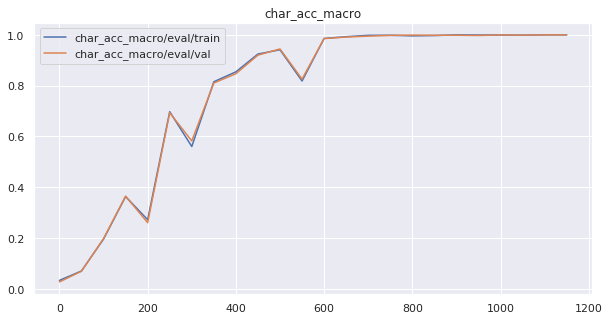

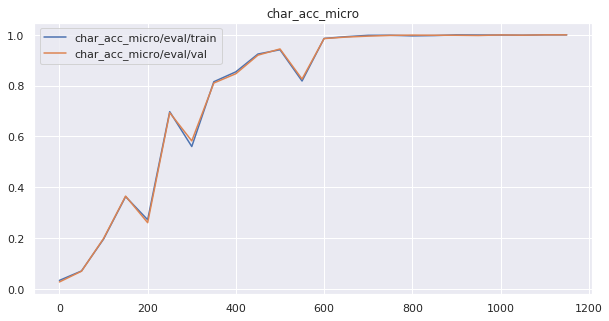

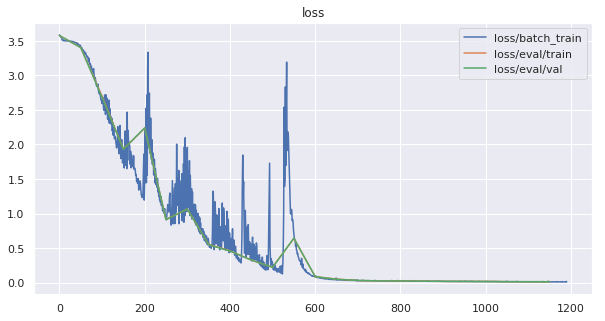

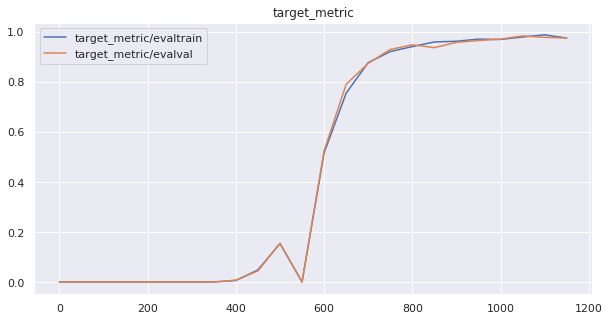

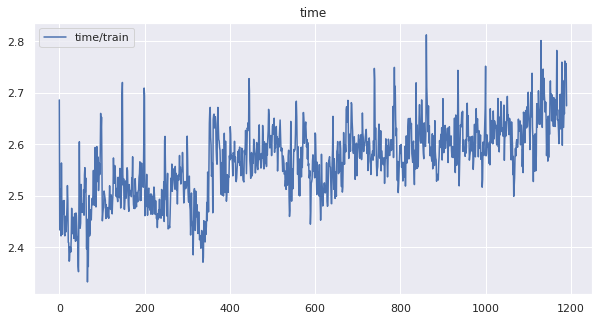

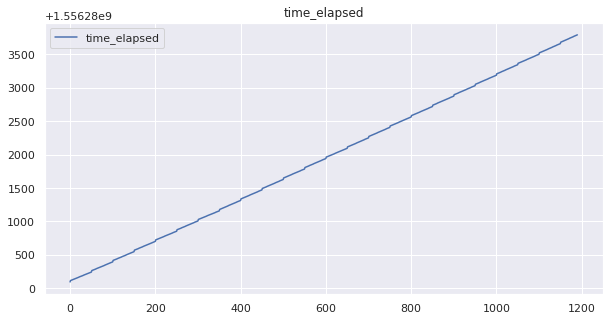

In [0]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)
except:
    pass

Переворачивать последовательности длиной 50 символов уже более сложная задача, но и с ней модель с вниманием справляется буквально за одну эпоху, но ввиду сложности модели, для вычисления этой эпохи потребовался целый час

### Biderectional RNN with length = 100

In [0]:
train, val, test = generate_random_reverse_dataset(
    n_samples=100000,
    max_len=100,
    token_list=list('йцукенгшщзхъфывапролджэячсмитьбю')
)

train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)

loss_object = Seq2SeqUser(train)

In [0]:
seq2seq_model = AttentionModel(
    64, 128, 3, 2, len(train.encoder),
    train.sos_id, train.eos_id,
    use_attention=True,
    params={'encoder_use_last_valid_state':True},
)

params = {
    "epochs":20,
    "teacher_forcing_prob":0.5,
    "log_params":{
        "figsize":(10, 5),
        "show_every":10
    },
    "validate_every":50,
    "validation_max_batches":10,
    "print_eval_max":5
}

In [0]:
optimizer = torch.optim.Adam(seq2seq_model.parameters())
iteration_callback = StepLR(optimizer, step_size=1000, gamma=0.3)
trainer = Trainer(seq2seq_model, optimizer, iteration_callback=iteration_callback)

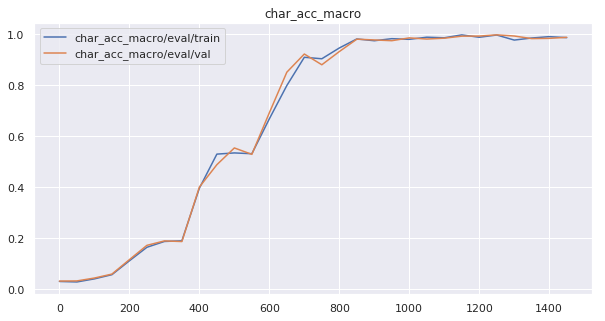

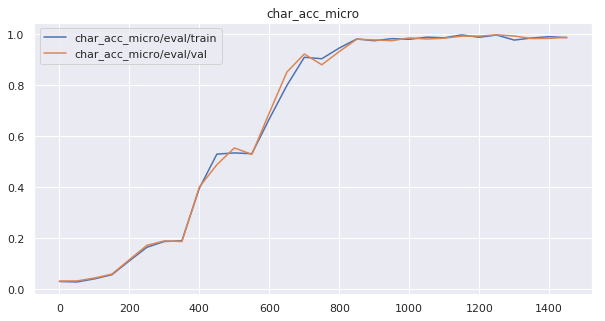

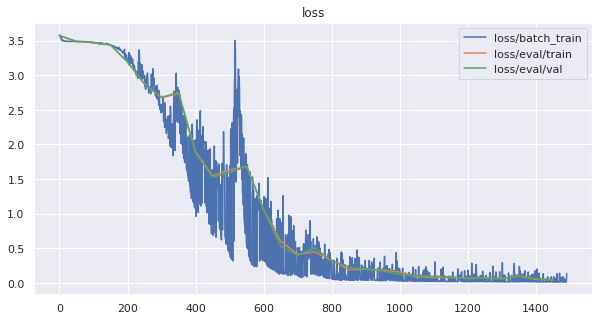

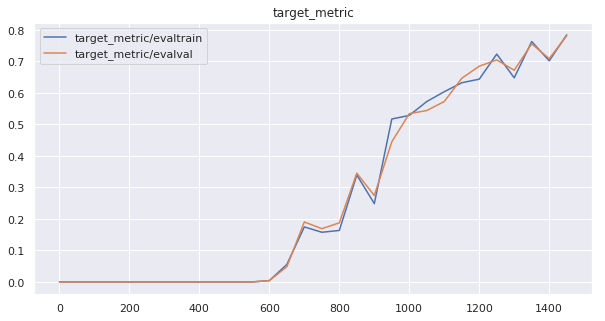

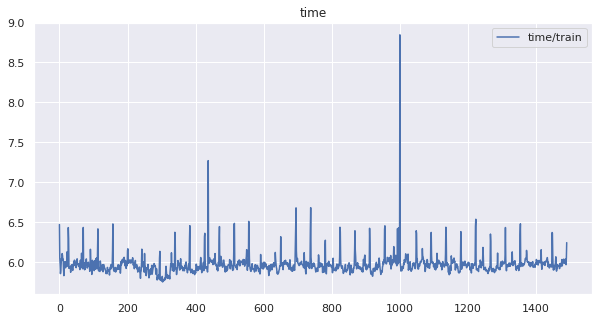

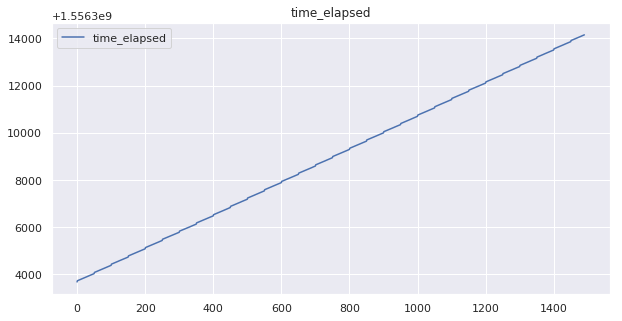

In [26]:
try:
    trainer.train(train_batcher=train_batcher, val_batcher=val_batcher, loss_object=loss_object, params=params)
except:
    pass

In [31]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

In [32]:
print(evaluate_result_test)
print(evaluate_result_train)
print(evaluate_result_val)

{'loss': 0.0603511752396822, 'target': 0.84, 'char_acc_micro': 0.998125, 'char_acc_macro': 0.998125}
{'loss': 0.04511407249155316, 'target': 0.854424504950495, 'char_acc_micro': 0.9987546410891089, 'char_acc_macro': 0.9987505856629705}
{'loss': 0.06427261772759185, 'target': 0.8295173267326733, 'char_acc_micro': 0.992973391089109, 'char_acc_macro': 0.9929720443542089}


Даже на большой задаче - реверсе последовательности из 100 символов двунаправленная сеть с внимание справляется хорошо. За 1 эпоху достигается почти единичная точность по метрике точности символов, и 0.8 на точном совпадении реверса. Правда, ввиду большого размера последователньости эта одна эпоха выполняется за большое число времени: почти 3 часа

### Attention visualization  

Now let's look at what the attention mechanism has learnt.

In [0]:
# Implement this function
# Tip: use seaborn heatmap
def visualize_attention(text_x, text_y, attention_weights):
    ### TODO

In [0]:
def use(line, model, loss_object, max_output_length):
    """
    line: line to transform
    model: seq2seq model
    loss_object: Seq2SeqUser for the model
    
    uses and prints
    """
    decoded, preds, debug_info = loss_object.use(seq2seq_model, list(line),
                                                 max_output_length=max_output_length)
    decoded = decoded[0]
    attention_weights = debug_info['attention_weights'][0]
    print(line, " -> ", decoded)
    

In [0]:
def use_and_visualize(line, model, loss_object, max_output_length):
    """
    line: line to transform
    model: seq2seq model
    loss_object: Seq2SeqUser for the model
    
    uses the model, prints the output and visualizes the attention mask
    """
    decoded, preds, debug_info = loss_object.use(seq2seq_model, list(line),
                                                 max_output_length=max_output_length)
    attention_weights = debug_info['attention_weights'][0]
    print(line, " -> ", decoded[0])
    visualize_attention(
        text_x=debug_info['sequence_padded'],
        text_y=debug_info['decoded_padded'],
        attention_weights=attention_weights
    )

In [0]:
# Use this if your loss object stores the samples from the evaluation
# for item in zip(loss_object.raw_samples[0], loss_object.attention_weights[0]):
#     visualize_attention(item[0][0], item[0][2], item[1])
#     plt.show()

Visualize attention weights and explain them.
Try to generate various inputs to produce interesting outputs.
Try to break the model and make in return nonsense for a reasonable input.

Describe what you see.
Why is attention like that? (Results may differ).

In [0]:
### TODO

For instance, try to change the length of the input sequence.

## Feedback

Tell us: what did you learn, what did you like, what puzzled you?

Научился работать с рекуррентными сетями и seq2seq моделями, впервые увидел как это примерно выглядит в коде, а не только в теории. Ввиду первого столкновения с такой задачей: реализации seq2seq моделей, это поставило в ступор. Большая сложность была как все теоретические знаняи применить при конкретной реализации. Почти все выходные были потрачены на осознание с чего начать. При появлении понимания дописывалось уже намного проще.

## Bonus: spelling correction data (3 points)

If you feel strength you can train a model on the competition data.
It is possible to train a model that achieves at least 0.5 of exact match accuracy on CPU with 8 GB of memory in 12 hours with moderate batches of at least 64, while watching videos and having >400 open tabs in browser (Firefox, actually).

If you beat this threshold (0.5 of exact match accuracy), you will be awarded the points for this part.
If your score is super high (to be determined after the deadline), you will be awarded by some points.

Also you can use the complete dataset (with retained correct entries) to improve models perfomance.

Maybe you need to play with teacher forcing params.

In [0]:
def load_surnames_dataset(csv_path, drop_correct, unique_x = True, train_val_test=[0.8,0.1,0.1]):
    """
    Loads the competition dataset.
    drop_correct: boolean flag whether to include the entries
    where X[i] == Y[i] (no misspelling)
    unique_x: every x in the dataset must be unique
    
    returns: 4 Seq2Seq datasets: train, val, test
    and correct: the dataset of surnames with no mistakes
    """
    
    data = pd.read_csv(csv_path)
    
    token_list = get_tokens(data)
    
    X = data['fullname']
    Y = data['fullname_true']
    
    mask = Y.isna()

    Y.loc[mask] = X[mask]
    
    
    new_X = []
    new_Y = []
    correct = []
    
    seen_x = set()
    for x, y in zip(X.values, Y.values):   
        if x in seen_x:
            continue
            
        if unique_x:
            seen_x.add(x)
        
        if x == y:
            correct.append(x)
            
        if drop_correct:
            if x != y:
                new_X.append(x)
                new_Y.append(y)
        else:
            new_X.append(x)
            new_Y.append(y)
    
    
    X = np.array(new_X)
    Y = np.array(new_Y)
    correct = np.array(correct)
    
    train, val, test = prepare_dataset(X, Y, token_list, train_val_test)
    correct = prepare_dataset(correct, correct, token_list, train_val_test=[0, 0, 1.0])[2]
    
    
    return train, val, test, correct
    
    

In [0]:
# When your are done playing with the toy data, try solving this problem
train, val, test, correct = load_surnames_dataset("./train.csv", drop_correct=True)

/home/itasarom/.programs/anaconda2/envs/torch/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
train_batcher = DataLoader(train, collate_fn=collate_sequences, batch_size=64, shuffle=True)
val_batcher = DataLoader(val, collate_fn=collate_sequences, batch_size=64, shuffle=False)
test_batcher = DataLoader(test, collate_fn=collate_sequences, batch_size=256, shuffle=False)
correct_batcher = DataLoader(correct, collate_fn=collate_sequences, batch_size=64, shuffle=False)

In [0]:
#### TODO

In [0]:
evaluate_result_test = evaluate_test(
    seq2seq_model, test_batcher, loss_object, max_batches=100000, tag="test", params=params
)

evaluate_result_train = evaluate_test(
    seq2seq_model, train_batcher, loss_object, max_batches=100, tag="train", params=params
)

evaluate_result_val = evaluate_test(
    seq2seq_model, val_batcher, loss_object, max_batches=100, tag="val", params=params
)

evaluate_result_correct = evaluate_test(
    seq2seq_model, correct_batcher, loss_object, max_batches=100, tag="correct", params=params
)